In [79]:
import pandas as pd
from read_db.CH import Getch
import pandahouse
from datetime import date,timedelta, datetime
import telegram
import seaborn as sns
import matplotlib.pyplot as plt
import io
sns.set(style ='ticks')
import hashlib
from scipy import stats
import numpy as np
#import swifter

In [22]:
def ab_split(id, salt ='exp_feed_1',n_groups=5):
    test_id = str(id) + '_' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest,16)
    return test_id_final_int % n_groups

In [23]:
user_data = Getch(
    '''
    select distinct user_id 
    --,source
    --,gender
    --,age
    --,country
    --,city
    --,os
    --,exp_group
    from simulator_20220520.feed_actions 
    '''
    ).df
user_data.head(2)

,user_id
0,33099
1,39117


In [24]:
user_data.user_id.apply(ab_split)

0         2
1         4
2         2
3         2
4         1
         ..
127157    4
127158    4
127159    3
127160    0
127161    3
Name: user_id, Length: 127162, dtype: int64

In [25]:
user_data['hash_group'] =user_data.user_id.apply(ab_split)

In [26]:
user_data.groupby('hash_group', as_index=False).agg({'user_id':'count'})

,hash_group,user_id
0,0,25311
1,1,25441
2,2,25549
3,3,25511
4,4,25350


In [30]:
user_data_2 = Getch(
    '''
    select xxHash64(toString(user_id)||'my_salt')%5 as group,
    uniqExact(user_id)
    from simulator_20220520.feed_actions 
    group by group
    '''
    ).df

In [31]:
user_data_2

,group,uniqExact(user_id)
0,0,25466
1,1,25442
2,2,25458
3,3,25622
4,4,25176


AA_тест Группы не должны отличаться друг от друга!!!

In [32]:
df = Getch(
    '''
    select exp_group
            ,user_id
            ,sum(action='like') as likes
            ,sum(action='view') as views
            ,likes/views as ctr
    from simulator_20220520.feed_actions 
    where toDate(time) between '2022-04-08' and '2022-04-14'
        and exp_group in (2,3)
    group by exp_group, user_id
    '''
    ).df

In [33]:
df

,exp_group,user_id,likes,views,ctr
0,3,115383,33,100,0.330000
1,3,10326,17,72,0.236111
2,3,123580,0,11,0.000000
3,3,2709,25,72,0.347222
4,2,14680,7,52,0.134615
...,...,...,...,...,...
12406,3,13489,9,30,0.300000
12407,2,16512,7,41,0.170732
12408,2,17146,3,27,0.111111
12409,3,122008,6,60,0.100000


In [35]:
df.groupby('exp_group', as_index=False).count()
#примерно одинаковое количество

,exp_group,user_id,likes,views,ctr
0,2,6150,6150,6150,6150
1,3,6261,6261,6261,6261


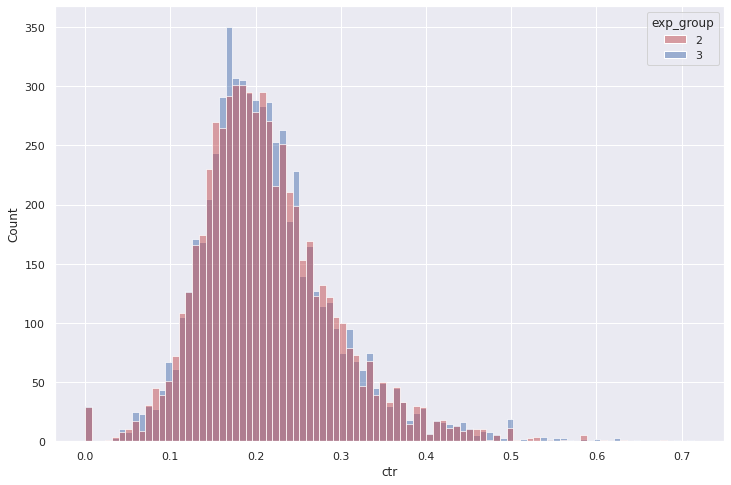

In [39]:
sns.set(rc={'figure.figsize':(12,8)})
groups = sns.histplot(data =df
                     ,x='ctr'
                     ,hue='exp_group'
                     ,palette = ['r','b']
                     ,alpha=0.5
                     ,kde=False)
#вроде группы +/- похожи

Пункт 1. Известное. t-критерий Стьюдента

среднее значение в двух группах.
легко получить доверительный интервал
считается быстро

0 гипотеза - средние равны, альтернативная - средние неравны.

Должны ли быть выборки нормальными?
правильное количество степеней свободы

Не работает: если распределение очень скошено, если много выбросов, если жирные выбросы это часть распредления

Главная проблема - требует явной оценки дисперсии исследуемой метрики.

In [42]:
stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)
#дисперсия необязательно одинаковая
#

Ttest_indResult(statistic=-0.6982272369218284, pvalue=0.48504818192842203)

Пункт 2. Тоже известное. тест Манна-Уитни

+ он такой же чувствительный как и первый
умеет проверять различие в средних
не привязан к распределению вашей метрики

-  не очень удобно интерпретируемая нулевая гипотеза
красится даже при равенстве средних
работает дольше


In [48]:
print(stats.mannwhitneyu(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr))

print('Отличие не прокрасилось')

A_gt_B = 0
for _ in range(10000):
    A_gt_B += df[df.exp_group == 2].ctr.sample().values[0] > df[df.exp_group == 3].ctr.sample().values[0]
print('B', A_gt_B/100,'% случаев А > B. Должно получиться около 50%.')

MannwhitneyuResult(statistic=19216305.0, pvalue=0.855784126805524)
Отличие не прокрасилось
B 49.28 % случаев А > B. Должно получиться около 50%.


In [49]:
A_gt_B = 0
for _ in range(10000):
    A_gt_B += df[df.exp_group == 2].ctr.sample().values[0] > df[df.exp_group == 3].ctr.sample().values[0]
print('B', A_gt_B/100,'% случаев А > B. Должно получиться около 50%.')
## AA тест сходится!!!

B 49.93 % случаев А > B. Должно получиться около 50%.


Итак, что нужно сделать: у нас есть данные АА-теста с '2022-04-17' по '2022-04-23'. 
Вам нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. 
На каждой итерации вам нужно сформировать подвыборки с повторением в 500 юзеров из 2 и 3 экспериментальной группы. 
Провести сравнение этих подвыборок t-testом.

In [66]:
df = Getch(
    '''
    select exp_group
            ,user_id
            ,sum(action='like') as likes
            ,sum(action='view') as views
            ,likes/views as ctr
    from simulator_20220520.feed_actions 
    where toDate(time) between '2022-04-17' and '2022-04-23'
        and exp_group in (2,3)
    group by exp_group, user_id
    '''
    ).df

In [67]:
stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)
#дисперсия необязательно одинаковая
#

Ttest_indResult(statistic=-0.7393597924958364, pvalue=0.45969873156476293)

In [68]:
print(stats.mannwhitneyu(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr))

print('Отличие не прокрасилось')

A_gt_B = 0
for _ in range(10000):
    A_gt_B += df[df.exp_group == 2].ctr.sample().values[0] > df[df.exp_group == 3].ctr.sample().values[0]
print('B', A_gt_B/100,'% случаев А > B. Должно получиться около 50%.')

MannwhitneyuResult(statistic=36124728.5, pvalue=0.5177480614337441)
Отличие не прокрасилось
B 49.82 % случаев А > B. Должно получиться около 50%.


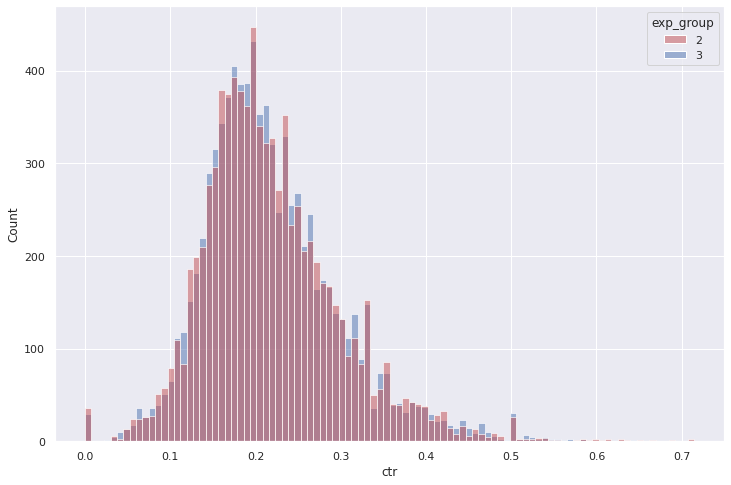

In [53]:
sns.set(rc={'figure.figsize':(12,8)})
groups = sns.histplot(data =df
                     ,x='ctr'
                     ,hue='exp_group'
                     ,palette = ['r','b']
                     ,alpha=0.5
                     ,kde=False)
#вроде группы +/- похожи

In [54]:
df[df.exp_group == 2].ctr.mean(), df[df.exp_group == 3].ctr.mean()

(0.21824612493721798, 0.21916104654193863)

In [60]:
df = Getch(
    '''
    with welchTTest(ctr, exp_index) as ttest
    
    select tupleElement(ttest,1) as statistic
            ,tupleElement(ttest,2) as p_value
    from
    (select exp_group
            ,case when exp_group = 2 then 0 else 1 end as exp_index
            ,user_id
            ,sum(action='like') as likes
            ,sum(action='view') as views
            ,likes/views as ctr
    from simulator_20220520.feed_actions 
    where toDate(time) between '2022-04-17' and '2022-04-23'
        and exp_group in (2,3)
    group by exp_group, user_id)
    '''
    ).df

In [61]:
df

,statistic,p_value
0,-0.73936,0.459699


In [63]:
df = Getch(
    '''
    with mannWhitneyUTest('two-sided')(ctr, exp_index) as mv
    
    select tupleElement(mv,1) as statistic
            ,tupleElement(mv,2) as p_value
    from
    (select exp_group
            ,case when exp_group = 2 then 0 else 1 end as exp_index
            ,user_id
            ,sum(action='like') as likes
            ,sum(action='view') as views
            ,likes/views as ctr
    from simulator_20220520.feed_actions 
    where toDate(time) between '2022-04-17' and '2022-04-23'
        and exp_group in (2,3)
    group by exp_group, user_id)
    '''
    ).df

In [64]:
df

,statistic,p_value
0,36106477.5,0.481668


## СГЛАЖИВАНИЕ CTR

In [74]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr)/(user_views + alpha)
    return smothed_ctr

In [70]:
df = Getch(
    '''
    select exp_group
            ,user_id
            ,sum(action='like') as likes
            ,sum(action='view') as views
            ,likes/views as ctr
    from simulator_20220520.feed_actions 
    where toDate(time) between '2022-04-17' and '2022-04-23'
        and exp_group in (2,3)
    group by exp_group, user_id
    '''
    ).df

In [71]:
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()
global_ctr_3 = df[df.exp_group == 3].likes.sum()/df[df.exp_group == 3].views.sum()

/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ctr'>

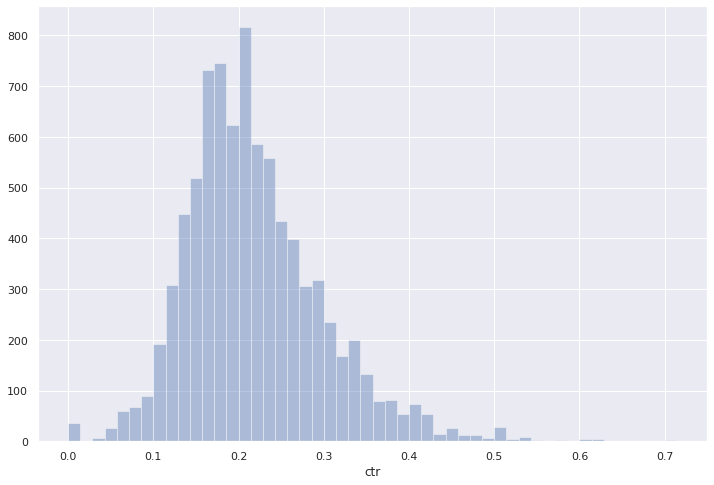

In [72]:
group2 = df[df.exp_group == 2].copy()
sns.distplot(group2.ctr, kde = False)

In [75]:
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'],x['views'],global_ctr_2,5), axis=1)

<AxesSubplot:xlabel='smothed_ctr'>

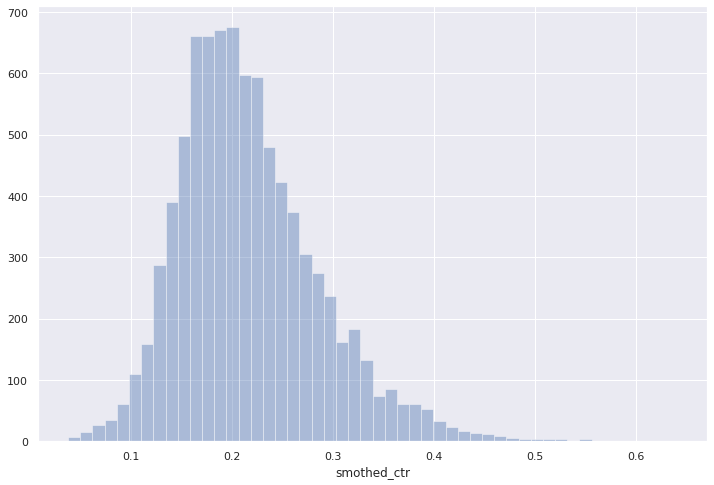

In [76]:
sns.distplot(group2.smothed_ctr, kde = False)

## Пуассоновский бутстреп
ОЧЕНЬ медленный

In [80]:
sample = [1,2,3,4,5,6,7,8,9,10]
# Есть выборка
df = pd.DataFrame()
df['data'] =[1,2,3,4,5,6,7,8,9,10]

# генерю перевыборку

[np.random.choice(df.data) for _ in range(len(sample))]

[2, 3, 10, 5, 6, 1, 1, 1, 7, 9]

In [81]:
#replace - выборка с возвращением
df.data.sample(10, replace=True).tolist()

[8, 2, 3, 3, 5, 1, 9, 4, 9, 4]

k = Binomial(n,1/n)

In [82]:
df = pd.DataFrame()
df['data'] =np.random.randint(1,100000,10000)

In [86]:
sample_length = 10000
p_to_be_taken = 1/sample_length
number_of_samples = 1000

sums = [sum(stats.binom(sample_length,
                        p_to_be_taken).rvs(sample_length)) for _ in range(number_of_samples)]

<AxesSubplot:ylabel='Count'>

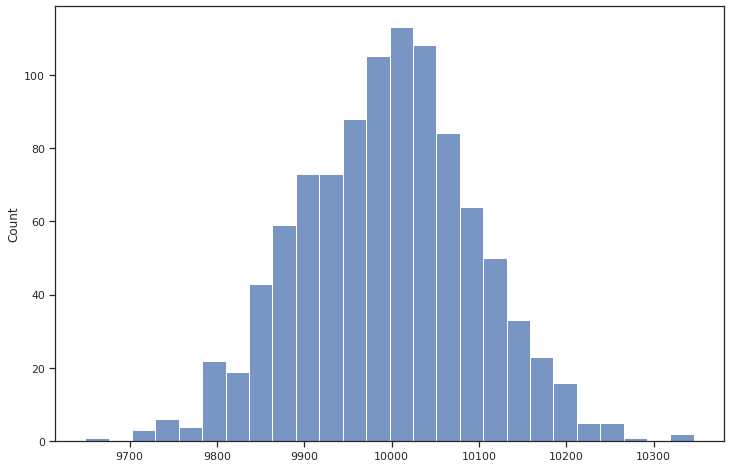

In [88]:
sns.histplot(sums)

In [99]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstrap1 = stats.poisson(1).rvs(
        (2000, len(likes1))).astype(np.int64)
    
    poisson_bootstrap2 = stats.poisson(1).rvs(
        (2000, len(likes2))).astype(np.int64)  
        
    globalCTR1=(poisson_bootstrap1*likes1).sum(axis=1)/(poisson_bootstrap1*views1).sum(axis=1)
    
    globalCTR2=(poisson_bootstrap2*likes2).sum(axis=1)/(poisson_bootstrap2*views2).sum(axis=1) 
    
    return globalCTR1, globalCTR2

In [95]:
df = Getch(
    '''
    select exp_group
            ,user_id
            ,sum(action='like') as likes
            ,sum(action='view') as views
            ,likes/views as ctr
    from simulator_20220520.feed_actions 
    where toDate(time) between '2022-04-17' and '2022-04-23'
        and exp_group in (2,3)
    group by exp_group, user_id
    '''
    ).df

likes1 = df[df.exp_group == 2].likes.to_numpy()
likes2 = df[df.exp_group == 3].likes.to_numpy()
views1 = df[df.exp_group == 2].views.to_numpy()
views2 = df[df.exp_group == 3].views.to_numpy()

In [100]:
ctr1, ctr2 = bootstrap(likes1,views1,likes2,views2)

<AxesSubplot:ylabel='Count'>

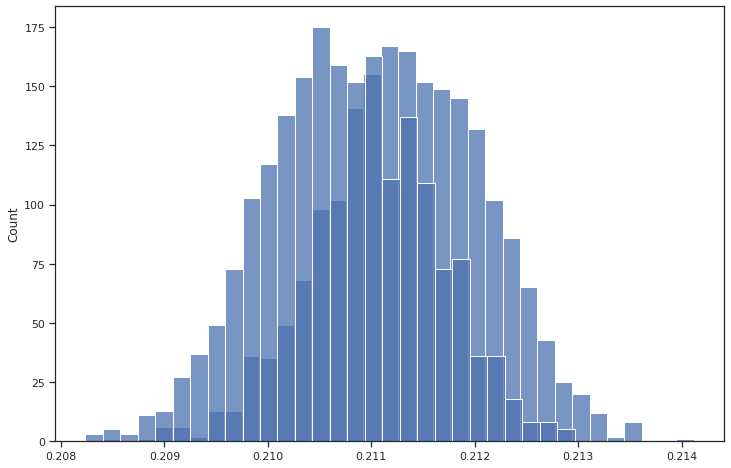

In [102]:
sns.histplot(ctr1)
sns.histplot(ctr2)

## Гистограмма разницы

<AxesSubplot:ylabel='Count'>

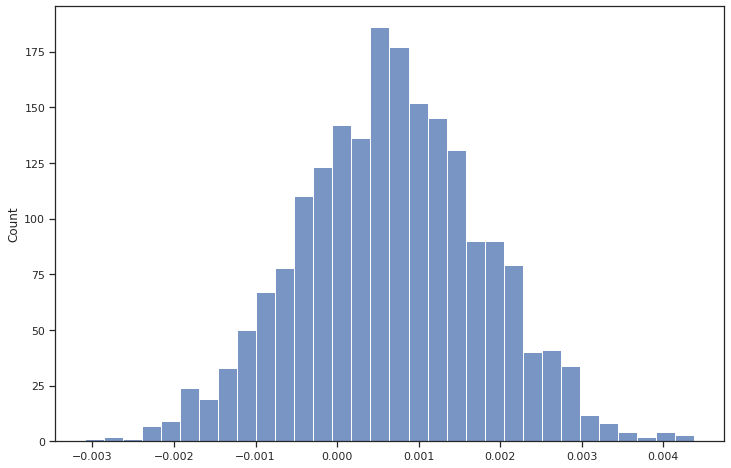

In [103]:
sns.histplot(ctr1-ctr2)

## Бакетное преобразование

In [104]:
df = Getch(
    '''
    select exp_group,bucket
            ,sum(likes)/sum(views) as bucket_ctr
            ,quantileExact(0.9)(ctr) as ctr9
    from (select exp_group
                ,xxHash64(user_id)%50 as bucket
                ,user_id
                ,sum(action='like') as likes
                ,sum(action='view') as views
                ,likes/views as ctr
        from simulator_20220520.feed_actions 
        where toDate(time) between '2022-04-17' and '2022-04-23'
            and exp_group in (2,3)
        group by exp_group, user_id)
    group by exp_group,bucket
    '''
    ).df

In [106]:
stats.mannwhitneyu(df[df.exp_group == 2].bucket_ctr,
                    df[df.exp_group == 3].bucket_ctr,
                    alternative = 'two-sided')

MannwhitneyuResult(statistic=1308.0, pvalue=0.6918139175147417)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

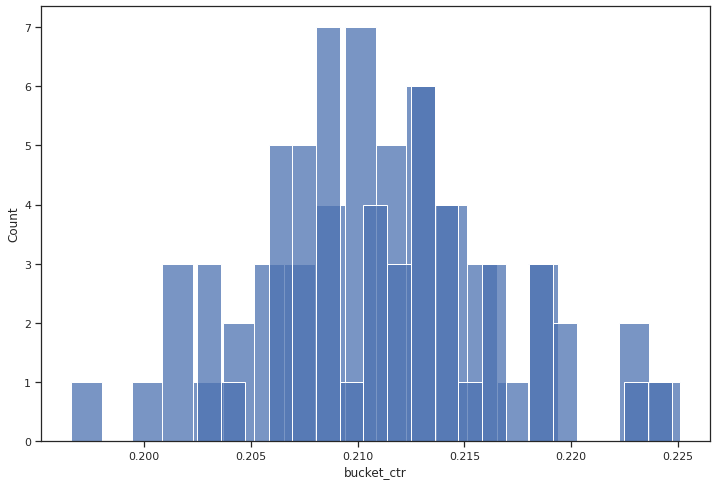

In [111]:
sns.histplot(df[df.exp_group == 3].bucket_ctr, bins =20)
sns.histplot(df[df.exp_group == 2].bucket_ctr, bins =20)

In [112]:
stats.ttest_ind(df[df.exp_group == 2].bucket_ctr,
                    df[df.exp_group == 3].bucket_ctr,
                    equal_var = False)

Ttest_indResult(statistic=0.5473397094077321, pvalue=0.5854154373001292)

<AxesSubplot:xlabel='ctr9', ylabel='Count'>

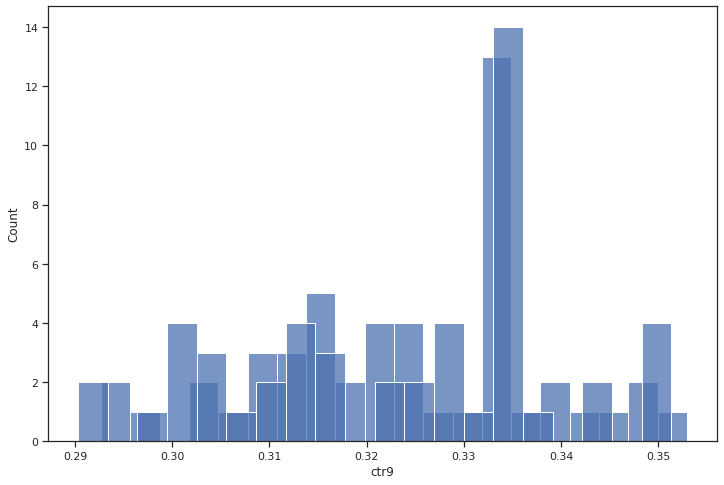

In [113]:
sns.histplot(df[df.exp_group == 3].ctr9, bins =20)
sns.histplot(df[df.exp_group == 2].ctr9, bins =20)

In [114]:
stats.mannwhitneyu(df[df.exp_group == 2].ctr9,
                    df[df.exp_group == 3].ctr9,
                    alternative = 'two-sided')

MannwhitneyuResult(statistic=1215.0, pvalue=0.8103505034829273)